In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass

import emcee
from scipy.optimize import minimize
from scipy.stats import t, norm

In [4]:
from surp import subgiants
import surp
import vice
from surp import gce_math as gcem
import arya

import sys
sys.path.append("../..")

from models.make_yields import make_yield_params

In [5]:
from singlezone import run_singlezone

In [6]:
def calc_model(**params):
    sz, h = run_singlezone(**params)
    
    return h.O_FE, h.C_O, h.sfr

In [7]:
def plot_sz(label="", **kwargs,):
    x, y, w = calc_model(**kwargs)
    plt.scatter(x, y, s=w, label=label)
    plt.xlabel("[Mg/Fe]")
    plt.ylabel("[C/Mg]")
    arya.Legend(loc=-1, color_only=True)

In [18]:
def make_yields(verbose=False, **kwargs):
    surp.set_yields(make_yield_params(**kwargs), verbose=verbose)


# Simple modeling

## AGB Yield properties

In [9]:
params = surp.YieldParams.from_file("../models/fiducial/yield_params.json")

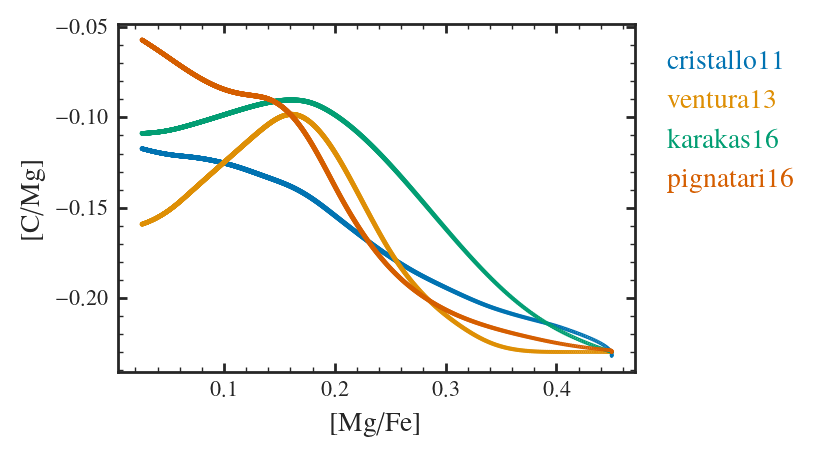

In [10]:
for model in surp.AGB_MODELS:
    surp.set_yields(params, Y_c_agb=model, alpha_c_agb=1, verbose=False)
    plot_sz(label=model)

In [11]:
params_a = make_yield_params(agb_model="A", zeta_agb=0, t_D=0.5)

In [12]:
params_a.Y_c_agb

'A'

In [13]:
surp.set_yields()

yields set to Magg et al. 2022 abundances
Yield settings
X        Z_solar    CC                             agb                            SN Ia                          

c        3.39e-03   2.28e-03 + 8.14e-01 (Z - Z0)   1.00 × cristallo11             0                              

n        1.04e-03   5.00e-04                       5.02e-04 M Z/Z0                0                              

o        7.33e-03   7.13e-03                       0                              0                              

mg       6.71e-04   6.52e-04                       0                              0                              

fe       1.37e-03   4.73e-04                       0                              7.70e-04                       





In [14]:
make_yields(agb_model="A", zeta_agb=0, t_D=0.2)


yields set to Magg et al. 2022 abundances
Yield settings
X        Z_solar    CC                             agb                            SN Ia                          

c        3.39e-03   2.20e-03 + 3.95e-02 (Z - Z0)   (5.51e-04 + 0.00e+00(Z-Zo)),   0                              
                                                   t_D=0.20, tau=0.30                                            

n        1.04e-03   5.00e-04                       5.02e-04 M Z/Z0                0                              

o        7.33e-03   7.13e-03                       0                              0                              

mg       6.71e-04   6.52e-04                       0                              0                              

fe       1.37e-03   4.73e-04                       0                              7.70e-04                       





yields set to Magg et al. 2022 abundances
Yield settings
X        Z_solar    CC                             agb                            SN Ia                          

c        3.39e-03   2.20e-03 + 5.33e-02 (Z - Z0)   1.45 × cristallo11             0                              

n        1.04e-03   5.00e-04                       5.02e-04 M Z/Z0                0                              

o        7.33e-03   7.13e-03                       0                              0                              

mg       6.71e-04   6.52e-04                       0                              0                              

fe       1.37e-03   4.73e-04                       0                              7.70e-04                       



yields set to Magg et al. 2022 abundances
Yield settings
X        Z_solar    CC                             agb                            SN Ia                          

c        3.39e-03   2.20e-03 + 3.95e-02 (Z - Z0)   (5.51e-04 + 0.00e+00(Z-Zo)),

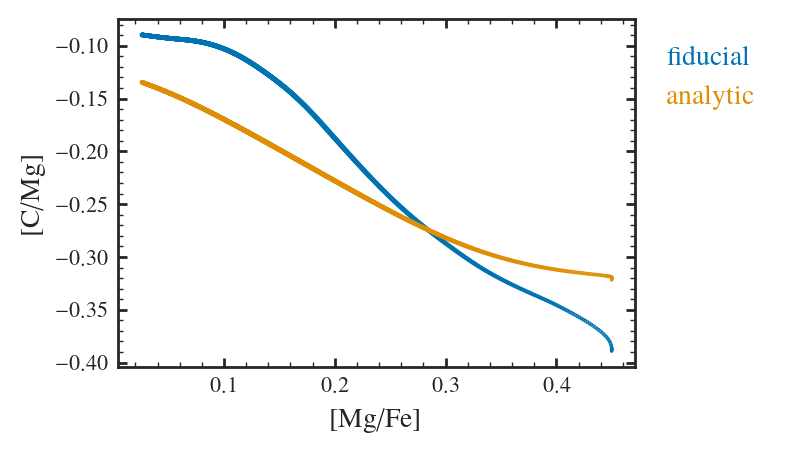

In [15]:
make_yields()
plot_sz(label="fiducial")
make_yields(agb_model="A", zeta_agb=0, t_D=0.2)
plot_sz(label="analytic")

yields set to Magg et al. 2022 abundances
Yield settings
X        Z_solar    CC                             agb                            SN Ia                          

c        3.39e-03   2.75e-03 + 3.95e-02 (Z - Z0)   (0.00e+00 + 0.00e+00(Z-Zo)),   0                              
                                                   t_D=0.10, tau=0.30                                            

n        1.04e-03   5.00e-04                       5.02e-04 M Z/Z0                0                              

o        7.33e-03   7.13e-03                       0                              0                              

mg       6.71e-04   6.52e-04                       0                              0                              

fe       1.37e-03   4.73e-04                       0                              7.70e-04                       



yields set to Magg et al. 2022 abundances
Yield settings
X        Z_solar    CC                             agb                          

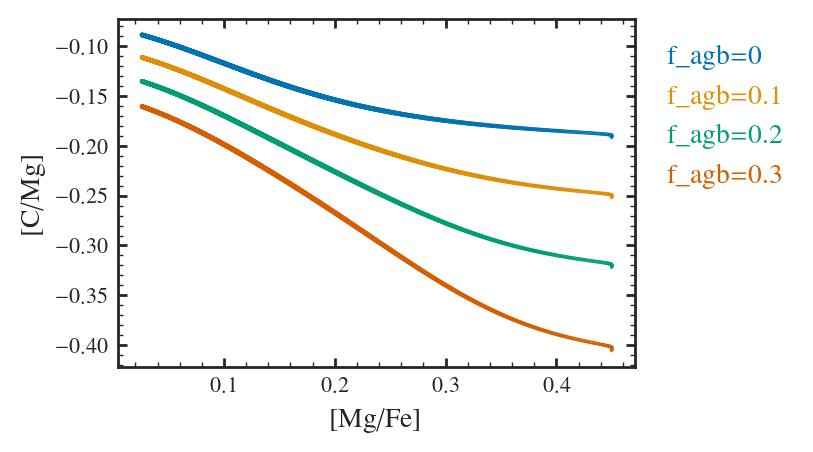

In [16]:
for model in [0, 0.1, 0.2, 0.3]:
    make_yields(agb_model="A", zeta_agb=0, f_agb=model)
    plot_sz(label=f"f_agb={model}")

yields set to Magg et al. 2022 abundances
Yield settings
X        Z_solar    CC                             agb                            SN Ia                          

c        3.39e-03   2.20e-03 + 3.95e-02 (Z - Z0)   (5.51e-04 + 0.00e+00(Z-Zo)),   0                              
                                                   t_D=0.00, tau=0.30                                            

n        1.04e-03   5.00e-04                       5.02e-04 M Z/Z0                0                              

o        7.33e-03   7.13e-03                       0                              0                              

mg       6.71e-04   6.52e-04                       0                              0                              

fe       1.37e-03   4.73e-04                       0                              7.70e-04                       



yields set to Magg et al. 2022 abundances
Yield settings
X        Z_solar    CC                             agb                          

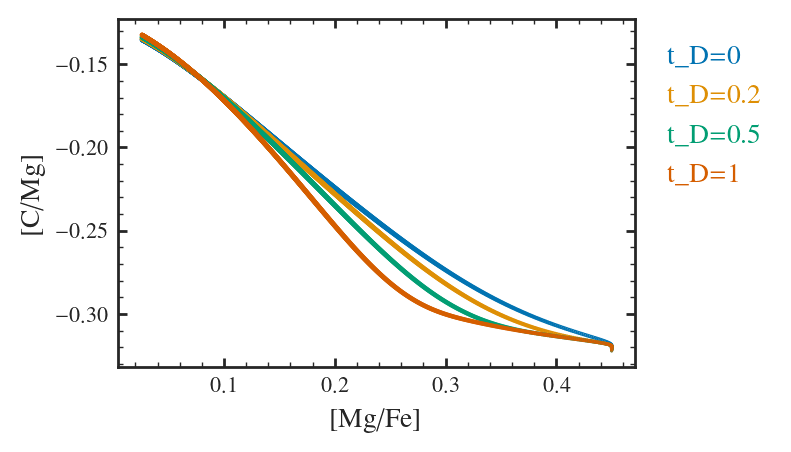

In [17]:
for model in [0, 0.2, 0.5, 1]:
    make_yields(agb_model="A", zeta_agb=0, t_D=model)
    plot_sz(label=f"t_D={model}")

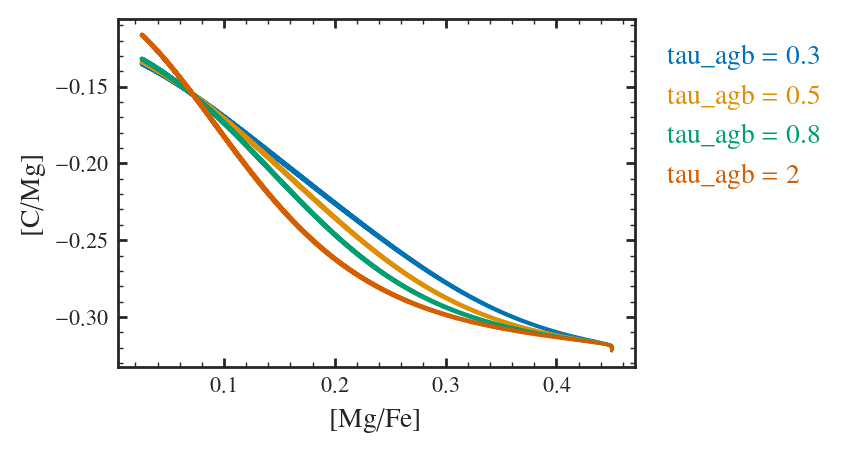

In [19]:
for model in [0.3, 0.5, 0.8, 2]:
    make_yields(agb_model="A", zeta_agb=0, tau_agb=model)

    plot_sz(label=f"tau_agb = {model}")

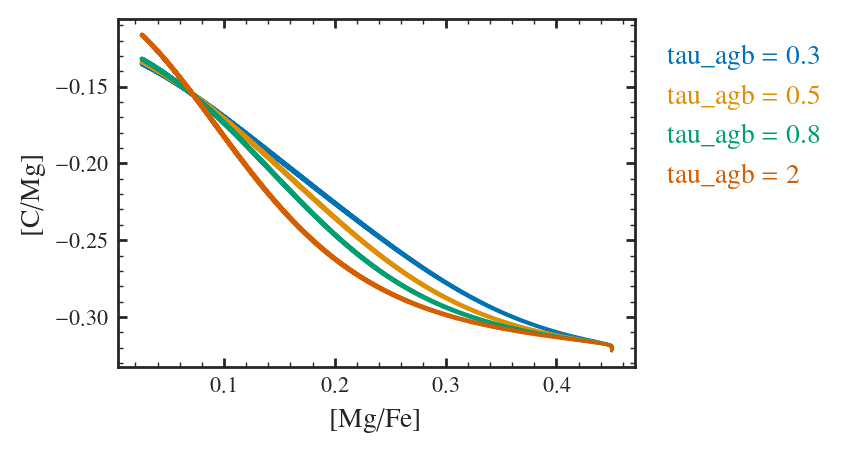

In [22]:
for model in [0.3, 0.5, 0.8, 2]:
    make_yields(agb_model="A", zeta_agb=0.00, tau_agb=model)

    plot_sz(label=f"tau_agb = {model}")

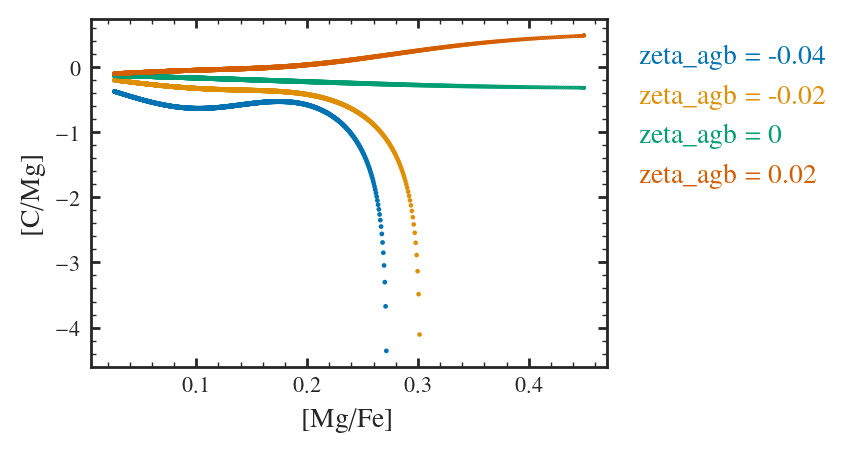

In [21]:
for model in [-0.04, -0.02, 0, 0.02]:
    make_yields(agb_model="A", zeta_agb=model)

    plot_sz(label=f"zeta_agb = {model}")
    

## CCSNe

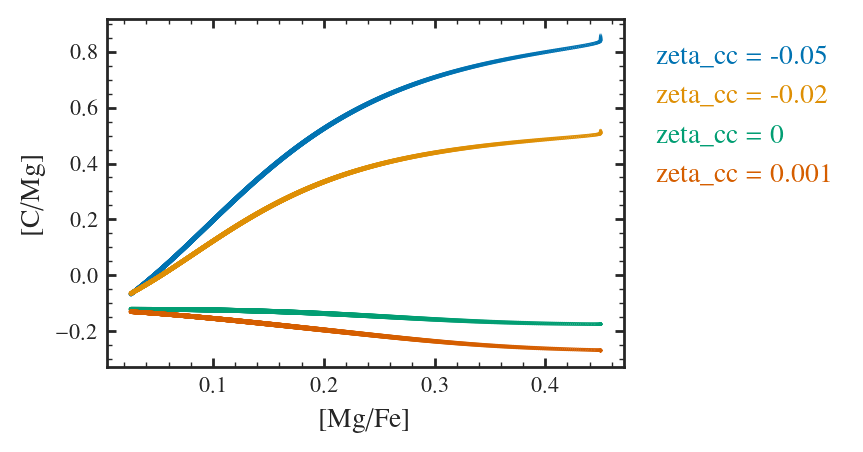

In [65]:
for model in [-0.05, -0.02, 0, 0.001]:
    make_yields(zeta_cc=model, agb_model="A", zeta_agb=0)
    plot_sz(label=f"zeta_cc = {model}")
    

In [35]:
make_yield_params(y_c_cc="BiLogLin")

YieldParams(yield_scale=1, mlr='larson1974', y_c_cc='BiLogLin', y0_c_cc=0.0022027168, zeta_c_cc=0.0019627619263157896, kwargs_c_cc={'y1': 0.0001}, Y_c_agb='cristallo11', alpha_c_agb=1.4491557894736842, kwargs_c_agb={'mass_factor': 1, 'no_negative': False, 'interp_kind': 'linear', 'low_z_flat': False}, y_c_ia=0, y0_n_cc=0.0005, zeta_n_cc=0, Y_n_agb='A', kwargs_n_agb={}, eta_n_agb=0.000502, y0_n_agb=0, y_fe_cc=0.000473, y_fe_ia=0.00077)

yields set to Magg et al. 2022 abundances
Yield settings
X        Z_solar    CC                             agb                            SN Ia                          

c        3.39e-03   2.20e-03 + 5.33e-02 (Z - Z0)   1.45 × cristallo11             0                              

n        1.04e-03   5.00e-04                       5.02e-04 M Z/Z0                0                              

o        7.33e-03   7.13e-03                       0                              0                              

mg       6.71e-04   6.52e-04                       0                              0                              

fe       1.37e-03   4.73e-04                       0                              7.70e-04                       



yields set to Magg et al. 2022 abundances
Yield settings
X        Z_solar    CC                             agb                            SN Ia                          

c        3.39e-03   2.20e-03 + 1.96e-03 [M/H]      1.45 × cristallo11          

(-1.0, 0.11670607843076473)

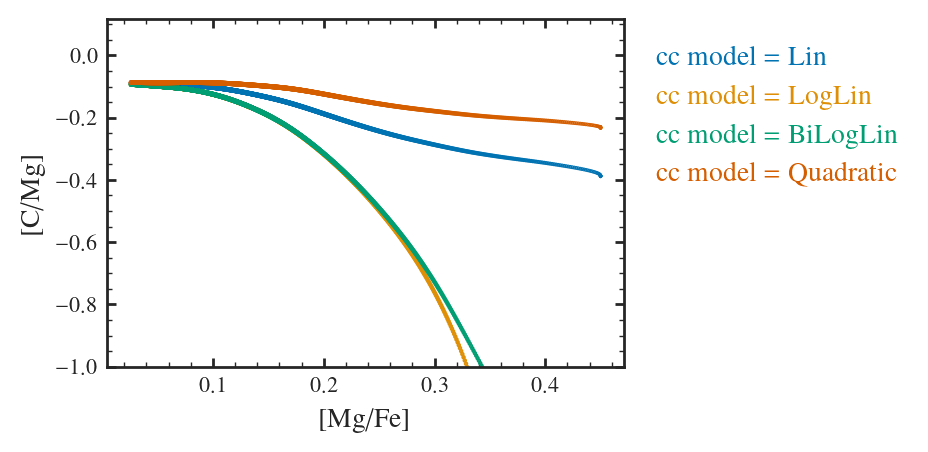

In [39]:
for model in ["Lin", "LogLin",  "BiLogLin", "Quadratic"]:
    make_yields(y_c_cc=model, verbose=True)
    plot_sz(label=f"cc model = {model}")

plt.ylim(-1)

## Iron

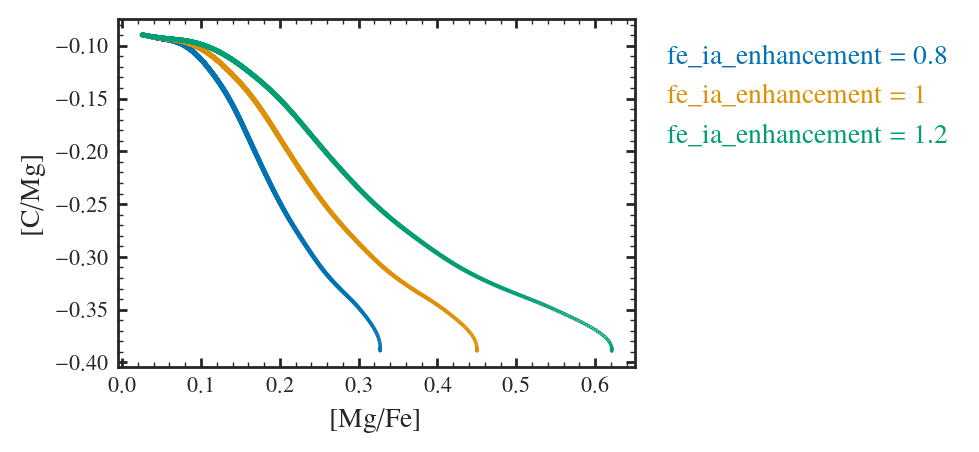

In [40]:
for model in [0.8, 1, 1.2]:
    make_yields(fe_ia_factor=model)
    plot_sz(label=f"fe_ia_enhancement = {model}")
    

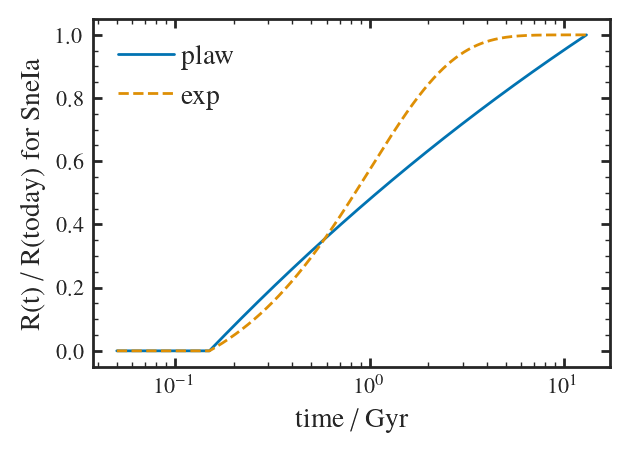

In [41]:
def dtd_1(t):
    return np.where(t > 0.15, t**(-1.1), 0)

def dtd_2(t):
    return np.where(t > 0.15, np.exp(-(t-0.15)), 0)

t = np.logspace(-1.3, np.log10(13), 1000)
dt = np.gradient(t)
R1 = np.cumsum(dtd_1(t)*dt)
R2 = np.cumsum(dtd_2(t)*dt)

plt.plot(t, R1 / R1[-1], label="plaw")
plt.plot(t, R2 / R2[-1], label="exp", ls="--")

plt.xscale("log")
plt.xlabel("time / Gyr")
plt.ylabel("R(t) / R(today) for SneIa ")
plt.legend()

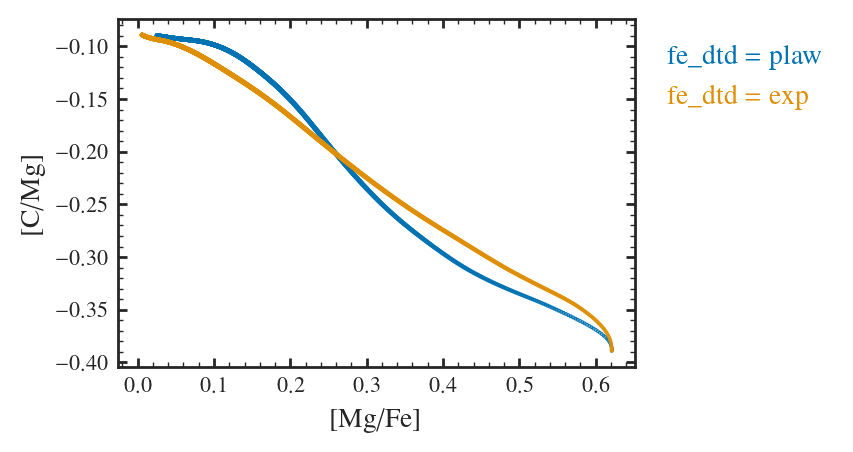

In [42]:
for model in ["plaw", "exp"]:
    plot_sz(label=f"fe_dtd = {model}", RIa=model)
    

## GCE Parameters

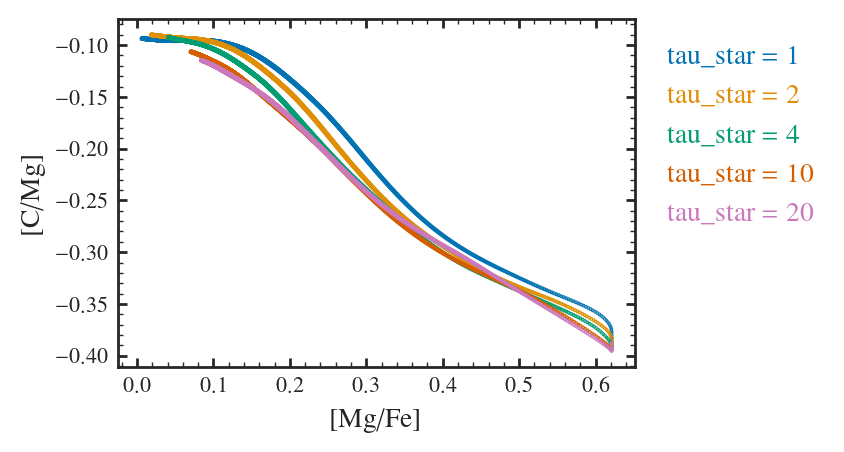

In [44]:
for model in [1, 2, 4, 10, 20]:
    plot_sz(label=f"tau_star = {model}", tau_star=model)
    

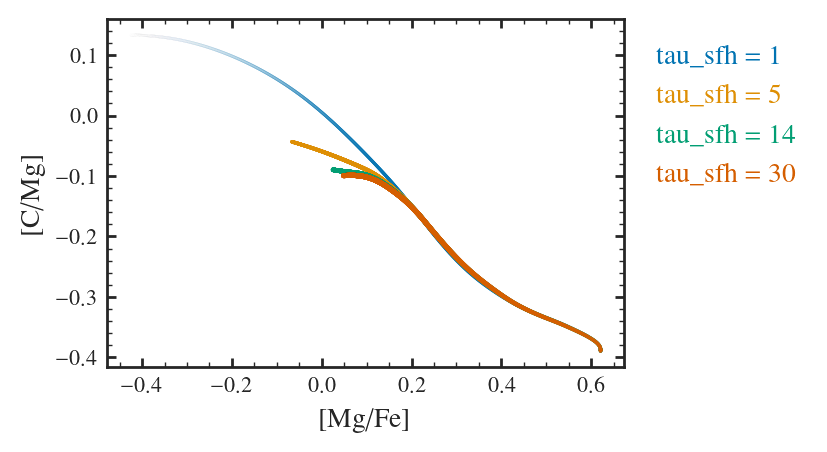

In [45]:
for model in [1, 5, 14, 30]:
    plot_sz(label=f"tau_sfh = {model}", tau_sfh=model)
    

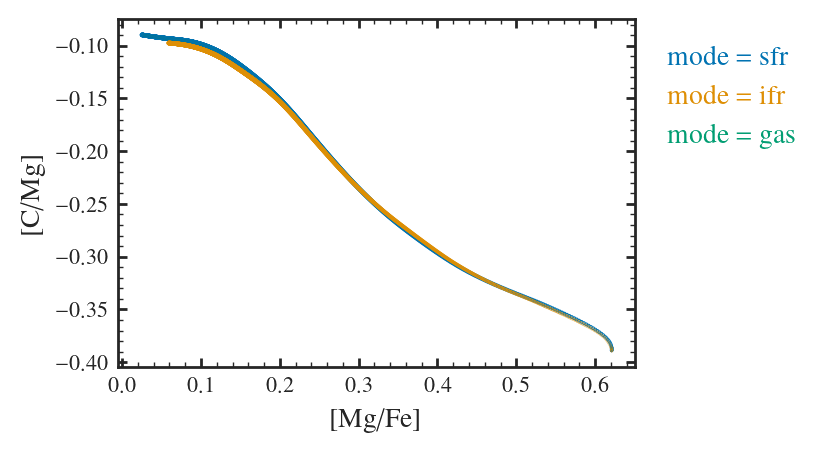

In [46]:
for model in ["sfr", "ifr", "gas"]:
    plot_sz(label=f"mode = {model}", mode=model)
    

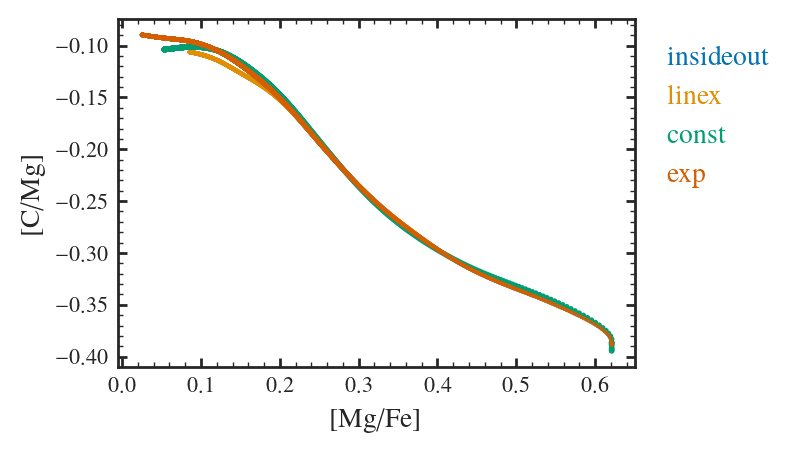

In [47]:
plot_sz(label=f"insideout", sfh=surp.simulation.sfh_models.insideout(tau_sfh=14))
plot_sz(label=f"linex", sfh=surp.simulation.sfh_models.linexp(tau_sfh=14))
plot_sz(label=f"const", sfh=lambda x: 1)
plot_sz(label="exp")


## Bimodality

In [48]:
t12 = 7

In [52]:
kwargs = dict()
sz1, h1 = run_singlezone(**kwargs)
sz2, h2 = run_singlezone(tau_sfh=3, tau_star=0.7, eta=0, t_end=t12, RIa="exp", **kwargs)

filt = np.array(h1["time"]) > t12 - 2
h1 = h1[filt]

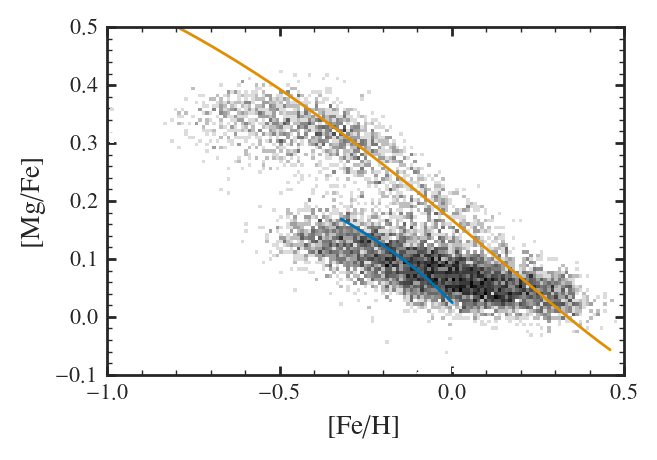

(-0.5, 0.1)

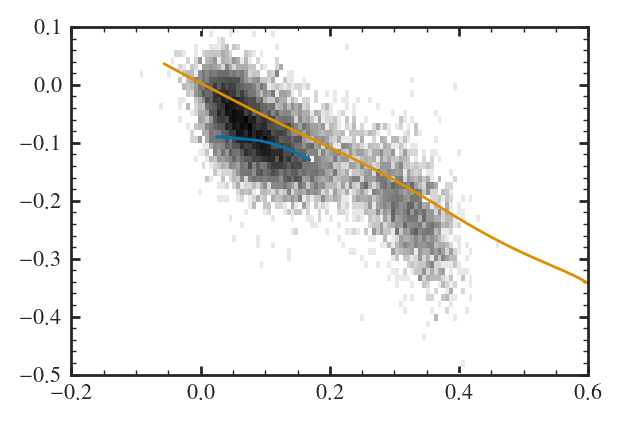

In [64]:

plt.plot(h1["[fe/h]"], h1.MG_FE)

plt.plot(h2["[fe/h]"], h2.MG_FE)

plt.hist2d(subgiants.FE_H, subgiants.MG_FE, 300, cmap="Greys", norm="log");
plt.xlim(-1, 0.5)
plt.ylim(-0.1, 0.5)
plt.xlabel("[Fe/H]")
plt.ylabel("[Mg/Fe]")
plt.show()


plt.plot(h1.MG_FE, h1.C_MG)
plt.plot(h2.MG_FE, h2.C_MG)
plt.hist2d(subgiants.MG_FE, subgiants.C_MG, 300, cmap="Greys", norm="log");
plt.xlim(-0.2, 0.6)
plt.ylim(-0.5, 0.1)

# MCMC attempts

In [8]:
def prob(x, y, xerr, yerr, xm, ym):
    return np.exp(-1/2 * ((y - ym)**2/yerr**2 + (x-xm)**2/xerr**2))

In [9]:
def log_prob(obs, model):
    x, y, xerr, yerr = obs
    xm, ym, w = model
    xm = xm.reshape((-1, 1))
    ym = ym.reshape((-1, 1))
    w = w.reshape((-1, 1)) 
    Σs = np.sum(w * prob(x, y, xerr, yerr, xm, ym), axis=0) # sum over model
    return np.sum(np.log(Σs)) # return log product of each data point
    
    

In [10]:
def normal(x, mu, sigma):
    return 1/np.sqrt(2*np.pi * sigma**2) * np.exp(-(x-mu)**2 / (2*sigma**2))

In [11]:
def log_normal(x, mu, sigma):
    return np.where(x >= 0, normal(np.log(x), np.log(mu), sigma), 0)

In [54]:
class SZModel:
    def __init__(self):
        self.eta = 2
        self.tau_agb = 0.5
        self.f_agb = 0.2
        self.A = 0
        self.t_b = 8
        self.tau_b = 2
        self.tau_sfh = 5
    
    def set_params(self, theta):
        self.eta, self.tau_agb, self.f_agb = theta
        
    
    def log_prior(self):
        p = 0
        p += np.log(log_normal(self.eta, 0.5, 2))
        p += np.log(log_normal(self.tau_agb, 2, 0.5))
        p += np.log(normal(self.f_agb, 0.2, 0.1))

        return p
    
    def predict(self):
        return calc_model(eta=self.eta, tau_agb=self.tau_agb, f_agb=self.f_agb, 
                          tau_b=self.tau_b, A=self.A, t_b=self.t_b, tau_sfh=self.tau_sfh)
        
    def get_params(self):
        return [self.eta, self.tau_agb, self.f_agb]

    def log_likelihood(self, theta, obs):
        self.set_params(theta)
        model = self.predict()
        return log_prob(obs, model) + self.log_prior()

In [55]:
def plot_model(model, theta, **kwargs):
    model.set_params(theta)
    x, y, w = model.predict()
    plt.scatter(x, y, s=w, **kwargs)

In [56]:
x = subgiants.MG_FE
y = subgiants.C_MG
xerr = subgiants.MG_FE_ERR
yerr = subgiants.C_MG_ERR

filt = ~np.isnan(x)
filt &= ~np.isnan(y)
filt &= ~np.isnan(xerr)
filt &= ~np.isnan(yerr)
print(np.sum(~filt))
filt &= ~subgiants.high_alpha

x = x[filt].values
y = y[filt].values
xerr = xerr[filt].values
yerr = yerr[filt].values

obs = [x, y, xerr, yerr]

0


In [57]:
model = SZModel()
model.t_b = 5
model.tau_sfh = 5
model.tau_b = 2
model.A = 0
model.f_agb = 0.2
model.eta= 1
th0 = model.get_params()


(-0.5, 0.2)

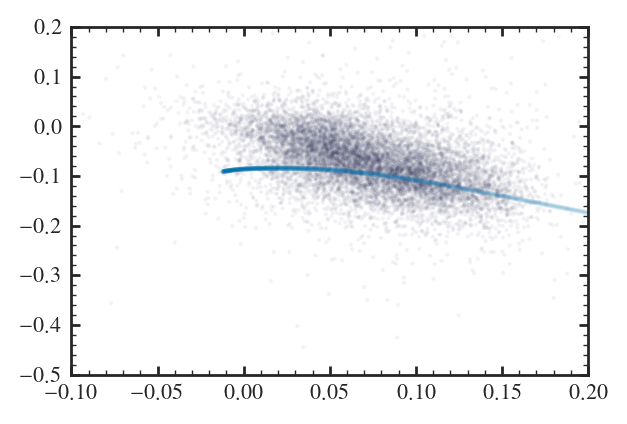

In [58]:
plt.scatter(x, y, s=0.3, alpha=0.05, c=subgiants.high_alpha[filt])
plot_model(model, th0, alpha=0.05)
plt.xlim(-0.1, 0.2)
plt.ylim(-0.5, 0.2)

In [59]:
model = SZModel()
model.t_b = 0
model.tau_sfh = 4
model.tau_b = 1
model.A = 0.1
model.f_agb = 0.3
model.eta= 0.
th0 = model.get_params()


/users/PAS2232/aeyobd/VICE/vice/core/singlezone/singlezone.py:258: ScienceWarning: Closed-box GCE models have been shown to overpredict the metallicities of solar neighborhood stars. This was known as the G-dwarf problem (Tinsley 1980, Fundamentals of Cosmic Phys., 5, 287). Outflows have been shown to be necessary for maintaining long-term chemical equilibrium (Dalcanton 2007, ApJ, 658, 941).
  self.__c_version = c_singlezone(**kwargs)


(-0.5, 0.2)

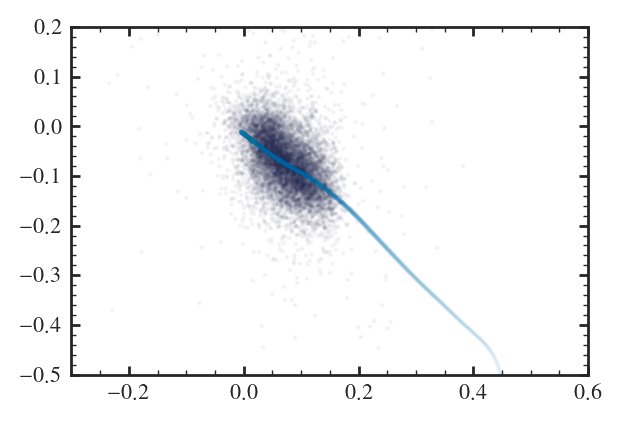

In [60]:
plt.scatter(x, y, s=0.3, alpha=0.05, c=subgiants.high_alpha[filt])
plot_model(model, th0, alpha=0.05)
plt.xlim(-0.3, 0.6)
plt.ylim(-0.5, 0.2)

In [64]:
model = SZModel()
th0 = model.get_params()

In [ ]:
nll = lambda args, obs: -model.log_likelihood(args, obs)

Nparams = len(th0)

initial = th0 * (1 +  0.02 * np.random.randn(Nparams))
soln = minimize(nll, initial, args=obs)

/users/PAS2232/aeyobd/VICE/vice/core/singlezone/singlezone.py:1797: VisibleRuntimeWarning: Functions of stellar mass and metallicity for asymptotic giant branch star yields may significantly increase the required integration time, especially for fine timestepping.
  return self.__c_version.run(output_times, capture = capture,
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: c
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: o
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: mg
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with thi

In [63]:
soln.x / initial

ValueError: operands could not be broadcast together with shapes (4,) (3,) 

In [ ]:
initial

In [ ]:
soln.x

In [ ]:
plot_model(model, soln.x)


(-0.5, 0.2)

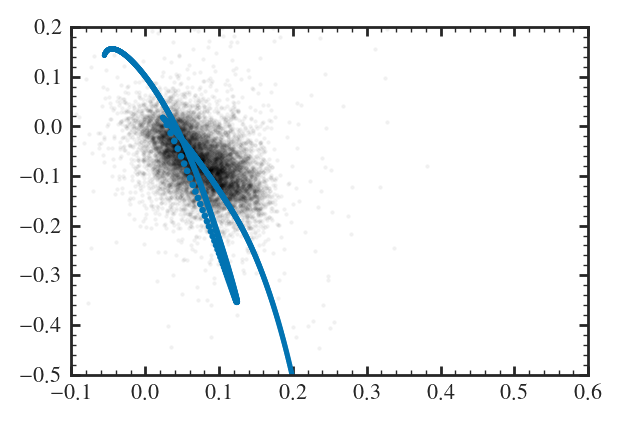

In [44]:
plt.scatter(x, y, s=0.3, alpha=0.05, color="k")
plot_model(model, soln.x)
plt.xlim(-0.1, 0.6)
plt.ylim(-0.5, 0.2)

In [ ]:
Nwalkers = 2*Nparams
pos = soln.x* (1 + 0.01 * np.random.randn(Nwalkers, Nparams))

sampler = emcee.EnsembleSampler(
    Nwalkers, Nparams, model.log_likelihood, args=[obs]
)
sampler.run_mcmc(pos, 100, progress=True)

/users/PAS2232/aeyobd/VICE/vice/core/singlezone/singlezone.py:1797: VisibleRuntimeWarning: Functions of stellar mass and metallicity for asymptotic giant branch star yields may significantly increase the required integration time, especially for fine timestepping.
  return self.__c_version.run(output_times, capture = capture,
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: c
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: o
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: mg
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with thi

In [50]:
import corner

In [51]:
flat_samples = sampler.get_chain(discard=10, thin=1, flat=True)

AttributeError: you must run the sampler with 'store == True' before accessing the results

In [ ]:
fig = corner.corner(flat_samples, labels=[r"eta", "$tau_agb$", "$f_{\rm agb}$"]);

In [ ]:
sz_params()

In [ ]:
import arya

In [ ]:
arya.medianplot(subgiants, "MG_FE", "C_MG", binsize=100)

In [ ]:
for i in range(len(flat_samples)):
    plot_model(flat_samples[i, :], alpha=0.01, color="blue")

plt.scatter(x, y, s=0.3, alpha=0.05, color="k")
arya.medianplot(subgiants, "MG_FE", "C_MG", binsize=100)
plt.xlim(-0.1, 0.6)
plt.ylim(-0.5, 0.2)